In [1]:
#@title Imports
import numpy as np
import random
from matplotlib import pyplot as plt
# from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import pandas as pd
from tqdm import tqdm

In [2]:
#@title Functions for generating inputs and states

# Defining different reservoirs to experiment with

# h       - reservoir state
# W and u - reservoir weights
# x_t     - input
# dt      - time step

def fixed_point_reservoir(h, k, D, x_t, dt):
    noise = D*np.random.normal(0, dt)
    return h + (-k*h + x_t + noise)*dt

# function which compiles the steps to generate inputs and reservoir states
# input: reservoir function (optional, will default to tanh)
def generate_states_lorenz(reservoir=fixed_point_reservoir,
                           num_steps=100000, dt=0.0001,
                           initial_conditions = (0., 1., 1.05)):
  def lorenz(xyz, *, s=10, r=28, b=2.667):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three-dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])

  xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
  xyzs[0] = initial_conditions  # Set initial values

  # x, y, z = [0] * 10001, [0] * 10001, [0] * 10001
  # x[0], y[0], z[0] = xyzs[0]

  # Step through "time", calculating the partial derivatives at the current point
  # and using them to estimate the next point
  print("Generating Inputs")
  for i in tqdm(range(num_steps)):
      xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

  random.seed(10)
  k = 1
  D = .1
  h = np.array([0])

  h_list = np.empty((num_steps + 2, 1))
  h_list[0] = h
  x_list = xyzs.T[0]

  print("Generating Reservoir States")
  for i in tqdm(range(len(x_list))):
    # see "defining different reservoirs" cell for more details on the reservoir
    h = reservoir(h, k, D, x_list[i], dt)
    h_list[i+1] = h

  return xyzs, h_list

In [3]:
#@title Functions for training readout layer

def generate_offsets(input, reservoir_state, tau):
  if tau == 0:
    return input, reservoir_state[1:]
  elif tau > 0:
    return input[tau:], reservoir_state[1:-tau]
  else:
    return input[:tau], reservoir_state[1-tau:]

def train_model(x, y, model):
    # Flatten reservoir states for use as input features
    emissions = np.array(y)  # Target outputs (emissions)

    split_index = int(0.8 * len(x))  # 80% for training, 20% for testing

    # Split into training and testing sets
    X_train, X_test = x[:split_index], x[split_index:]
    emissions_train, emissions_test = y[:split_index], y[split_index:]

    # Initialize and train the regressor
    model = model # RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, emissions_train)

    # EVALUATING ON TRAINING
    emissions_pred_train = model.predict(X_train)
    r2_train =  r2_score(emissions_train, emissions_pred_train)
    mse_train = mean_squared_error(emissions_train, emissions_pred_train)

    # EVALUATE ON TESTING
    emissions_pred_test = model.predict(X_test)
    r2_test = r2_score(emissions_test, emissions_pred_test)
    mse_test = mean_squared_error(emissions_test, emissions_pred_test)

    return model, r2_train, r2_test, mse_train, mse_test

def testing_training_metrics(r2_train, r2_test, mse_train, mse_test):
  data = {
      " ": ["R^2", "MSE"],
      "Training": [r2_train, mse_train],
      "Testing": [r2_test, mse_test]
  }

  df = pd.DataFrame(data)

  return df

In [4]:
#@title Generating Lorenz attractor inputs and hidden states
xyzs, h_list = generate_states_lorenz(fixed_point_reservoir,
                                            num_steps=10000000, dt=0.0001,
                                            initial_conditions = (3, 3, 3))
x_list = xyzs.T[0][2000:]
y_list = xyzs.T[1][2000:]
z_list = xyzs.T[2][2000:]
h_x = h_list.T[0][2000:]

Generating Inputs


100%|██████████| 10000000/10000000 [01:13<00:00, 136276.41it/s]


Generating Reservoir States


100%|██████████| 10000001/10000001 [01:42<00:00, 97886.48it/s]


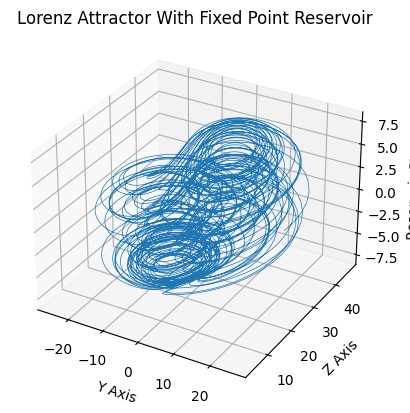

In [11]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(y_list[:1000000:100], z_list[:1000000:100], h_x[1:1000000:100], lw=0.5)
ax.set_xlabel("Y Axis")
ax.set_ylabel("Z Axis")
ax.set_zlabel("Reservoir States")
ax.set_title("Lorenz Attractor With Fixed Point Reservoir")

plt.show()

Plot System

In [ ]:
# # Plot
# ax = plt.figure().add_subplot(projection='3d')

# ax.plot(*xyzs[2000:].T, lw=0.5)
# ax.set_xlabel("X Axis")
# ax.set_ylabel("Y Axis")
# ax.set_zlabel("Z Axis")
# ax.set_title("Lorenz Attractor")

# plt.show()

Calculating memory and predictive capacity

In [12]:
y, x = generate_offsets(x_list, h_x, tau = 50)
x = [[i] for i in x] # fix dimensions
model = LinearRegression()
model,r2_train, r2_test, mse_train, mse_test = train_model(x, y, model)
print(testing_training_metrics(r2_train, r2_test, mse_train, mse_test))

         Training    Testing
0  R^2   0.286106   0.295686
1  MSE  44.929538  44.231559


In [13]:
r2 = []
tau_range = range(-20000, 20000, 20000)
for tau in tau_range:
  y, x = generate_offsets(x_list, h_x, tau = tau)
  # print("Offset:", tau)
  # print("lengths:", len(y), len(x))
  x = [[i] for i in x] # fix dimensions
  model = LinearRegression()
  model,r2_train, r2_test, mse_train, mse_test = train_model(x, y, model)
  r2.append(r2_train)

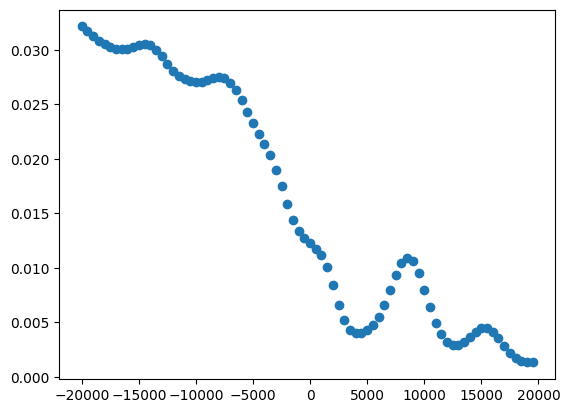

In [ ]:
plt.plot(tau_range, r2, 'o')
